In [1]:
import numpy as np
import pandas as pd 
import xml.etree.ElementTree as ET
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import decode_predictions
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import cv2
import random as rand

In [2]:
face_cascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")

In [6]:
def detect_face(idx):
    imgpath = 'images/maksssksksss' + str(idx) + '.png'
    img = cv2.imread(imgpath)
    img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
    faces = face_cascade.detectMultiScale(img, minNeighbors=3)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x, y),(x+w, y+h), (0, 255, 0), 2)
        
    plt.imshow(img)

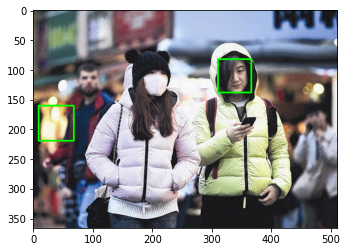

In [7]:
detect_face(0)

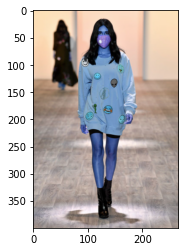

In [6]:
imgpath = 'images/maksssksksss' + str(767) + '.png'
img = cv2.imread(imgpath)
plt.imshow(img)

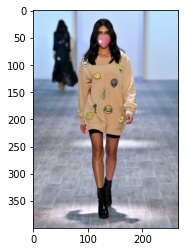

In [3]:
detect_face(767)

In [2]:
def read_img(idx):
    imgpath = 'images/maksssksksss' + str(idx) + '.png'
    img = cv2.imread(imgpath)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    plt.imshow(img)

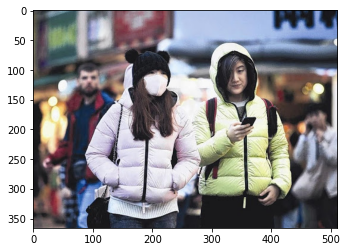

In [3]:
read_img(0)

In [4]:
def get_facial_info(idx):
    filepath = 'annotations/maksssksksss' + str(idx) + '.xml'
    tree = ET.parse(filepath)
    root = tree.getroot()
    
    infos = []
    for elem in root:
        if elem.tag == 'object':
            info = []
            
            for subelem in elem:
                if subelem.tag == 'name':
                    mask = subelem.text
                    if mask == 'without_mask':
                        info.append(0)
                    elif mask == 'mask_weared_incorrect':
                        info.append(1)
                    else:
                        info.append(2)
                        
                if subelem.tag == 'bndbox':
                    for coord in subelem:
                        info.append(int(coord.text))
            infos.append(info)
            
    return infos

In [5]:
def add_facial_box(idx):
    imgpath = 'images/maksssksksss' + str(idx) + '.png'
    img = cv2.imread(imgpath)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    infos = get_facial_info(idx)
    
    for (mask, x, y, w, h) in infos:
        edgecolor = ''
        
        if mask == 0:
            edgecolor = (255,0,0)
            
        elif mask == 1:
            edgecolor = (255,255,0)
            
        else:
            edgecolor = (0,255,0)
                         
        cv2.rectangle(img,(x,y), (w,h), edgecolor, 2)
        
    plt.imshow(img)

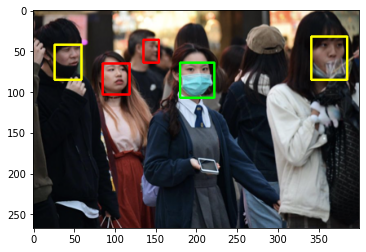

In [6]:
add_facial_box(250)

In [7]:
labels = []
faces = []
imgdir = os.listdir('images')

for i in range(len(imgdir)):
    imgpath = 'images/maksssksksss' + str(i) + '.png'
    img = cv2.imread(imgpath)
    
    for j in get_facial_info(i):
        labels.append(j[0])
        x,y,w,h = j[1:]
        
        face = img[y:h, x:w]
        face = cv2.resize(face, (224, 224))
        face = img_to_array(face)
        #face = preprocess_input(face)
        faces.append(face)
        
faces= np.array(faces, dtype="float32")
labels = np.array(labels)

In [8]:
label_enc = LabelEncoder()
labels = label_enc.fit_transform(labels)
labels = to_categorical(labels)
labels

array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

In [9]:
aug = ImageDataGenerator(
    zoom_range=0.1,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
    )

In [10]:
#define the model
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_shape=(224, 224, 3))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.25)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [11]:
#define the hyperparamets for traing te neural network
INIT_LR = 1e-4
EPOCHS = 5
BS = 32

In [12]:
#divide data into training and testing sets
(trainX, testX, trainY, testY) = train_test_split(faces, labels,
	test_size=0.2, stratify=labels, random_state=42)

In [13]:
#Free some space.I did this tep as the notebook was running out of space while training
del faces,labels

In [14]:
#Complie the model and train it
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS,
class_weight = {0:5 , 1:1, 2:10}) #Here we sets weights to each class. 
#Class having high weight will be considered more importat while training

Epoch 1/5
101/101 [==============================] - 74s 706ms/step - loss: 4.2823 - accuracy: 0.7350 - val_loss: 0.4354 - val_accuracy: 0.8368
Epoch 2/5
101/101 [==============================] - 70s 688ms/step - loss: 2.1783 - accuracy: 0.8382 - val_loss: 0.4017 - val_accuracy: 0.8552
Epoch 3/5
101/101 [==============================] - 71s 698ms/step - loss: 1.7924 - accuracy: 0.8588 - val_loss: 0.3693 - val_accuracy: 0.8810
Epoch 4/5
101/101 [==============================] - 75s 735ms/step - loss: 1.7537 - accuracy: 0.8497 - val_loss: 0.3530 - val_accuracy: 0.8896
Epoch 5/5
101/101 [==============================] - 80s 794ms/step - loss: 1.6889 - accuracy: 0.8712 - val_loss: 0.3564 - val_accuracy: 0.8908


[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.85      0.65      0.74       143
           1       0.00      0.00      0.00        25
           2       0.90      0.98      0.94       647

    accuracy                           0.89       815
   macro avg       0.58      0.54      0.56       815
weighted avg       0.86      0.89      0.87       815



c:\users\evfox\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\evfox\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\evfox\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

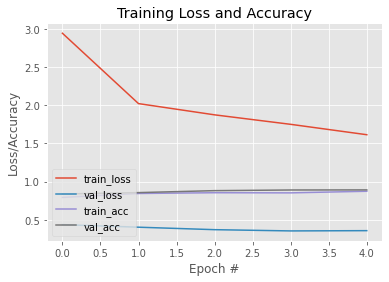

In [15]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=32)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs
	))

# # serialize the model to disk
# print("[INFO] saving mask detector model...")

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [16]:
model.save('mask_detect.h5')

In [17]:
model = load_model('mask_detect.h5')

In [18]:
predictions = model.predict(testX, batch_size=32)
results = imagenet_utils.decode_predictions(predictions)
print(results)

ValueError: `decode_predictions` expects a batch of predictions (i.e. a 2D array of shape (samples, 1000)). Found array with shape: (815, 3)

In [ ]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=32)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs
	))

# # serialize the model to disk
# print("[INFO] saving mask detector model...")

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [ ]:
decode_predictions

In [19]:
testX[0]

array([[[172., 152., 145.],
        [172., 152., 145.],
        [172., 152., 145.],
        ...,
        [ 46.,  41.,  46.],
        [ 46.,  41.,  46.],
        [ 46.,  41.,  46.]],

       [[172., 152., 145.],
        [172., 152., 145.],
        [172., 152., 145.],
        ...,
        [ 46.,  41.,  46.],
        [ 46.,  41.,  46.],
        [ 46.,  41.,  46.]],

       [[172., 152., 145.],
        [172., 152., 145.],
        [172., 152., 145.],
        ...,
        [ 46.,  41.,  46.],
        [ 46.,  41.,  46.],
        [ 46.,  41.,  46.]],

       ...,

       [[161., 137., 125.],
        [161., 137., 125.],
        [161., 137., 125.],
        ...,
        [207., 208., 208.],
        [207., 208., 208.],
        [207., 208., 208.]],

       [[161., 137., 125.],
        [161., 137., 125.],
        [161., 137., 125.],
        ...,
        [207., 208., 208.],
        [207., 208., 208.],
        [207., 208., 208.]],

       [[161., 137., 125.],
        [161., 137., 125.],
        [161., 1

In [20]:
test1 = model.predict(testX, batch_size=32)
test1

array([[0.04934753, 0.00322264, 0.94742984],
       [0.01619191, 0.002667  , 0.9811411 ],
       [0.00136429, 0.00231782, 0.99631786],
       ...,
       [0.00241013, 0.00302149, 0.99456847],
       [0.02059031, 0.00262454, 0.9767851 ],
       [0.13526876, 0.01320069, 0.85153055]], dtype=float32)

In [21]:
test1[0]

array([0.04934753, 0.00322264, 0.94742984], dtype=float32)

In [22]:
test1.shape

(815, 3)

In [23]:
testX.shape

(815, 224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


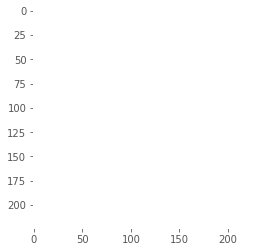

In [27]:
testimg = testX[0]
testimg = cv2.cvtColor(testimg, cv2.COLOR_RGB2BGR)
plt.imshow(testimg)